**Core question:** Are simpler words more commonly used than less simple words? 

**Proxy for simplicity:** Number of syllables in a word

In [51]:
# Importing Libraries 

import pandas as pd
import nltk
from nltk.corpus import cmudict
import string
import numpy as np

In [52]:
# Import simple syllable library and dictionary 

d = cmudict.dict()
def nsyl(word):
  return [len(list(y for y in x if y[-1].isdigit())) for x in d[str(word).lower()]] 

In [53]:
# Reading in SUBTLEX Frequencies

freq_data1 = pd.read_csv("SUBTLEXus74286wordstextversion.txt", sep="	", names=["Word1","FREQcount","CDcount","FREQlow","Cdlow","Freq_Per_Mil1","Log_Freq_Per_Mil1","SUBTLCD","Lg10CD"])
freq_data1 = freq_data1[["Word1","Freq_Per_Mil1","Log_Freq_Per_Mil1"]]

freq_data2 = pd.read_csv("SUBTLEXus74286wordstextversion.txt", sep="	", names=["Word2","FREQcount","CDcount","FREQlow","Cdlow","Freq_Per_Mil2","Log_Freq_Per_Mil2","SUBTLCD","Lg10CD"])
freq_data2 = freq_data2[["Word2","Freq_Per_Mil2","Log_Freq_Per_Mil2"]]

In [54]:
# Reading in synonym dataframe from eacl2017
adj=pd.read_csv("eacl2017_Syll/adjtrain.txt", sep="	", header=None, names=["Word1", "Word2","Synonym"])
noun=pd.read_csv("eacl2017_Syll/nounstrain.txt", sep="	", header=None, names=["Word1", "Word2","Synonym"])
verb=pd.read_csv("eacl2017_Syll/verbstrain.txt", sep="	", header=None, names=["Word1", "Word2","Synonym"])

frames = [adj,noun,verb]

data = pd.concat(frames)

# Filtering out antonyms
data = data[data.Synonym == 0]
data = data[["Word1", "Word2"]]


print(data)

            Word1       Word2
1     precipitous       steep
2        mystical  mysterious
4           stout         fat
7       insulting     abusive
8           heavy        deep
...           ...         ...
2502   intimidate       bully
2506       defend      forbid
2507          put         fix
2510        shock     outrage
2511       direct    organize

[5184 rows x 2 columns]


In [57]:

# Adding column for syllables 
data["Word1_Syll"] = ""
data["Word2_Syll"] = ""

for index, row in data.iterrows():
    row["Word1_Syll"] = nsyl(row["Word1"])[0]
    row["Word2_Syll"] = nsyl(row["Word2"])[0]
    
result = pd.merge(data,freq_data1,on="Word1")
final_df = pd.merge(result,freq_data2,on="Word2")

In [58]:
final_df['Syll_Delta'] = final_df['Word1_Syll'] - final_df['Word2_Syll']
final_df['Freq_Delta'] = final_df['Log_Freq_Per_Mil1'] - final_df['Log_Freq_Per_Mil2']

final_df['Syll_Delta'],final_df['Freq_Delta']=np.where((final_df['Syll_Delta']<=0),(-final_df['Syll_Delta'],-final_df['Freq_Delta']),(final_df['Syll_Delta'],final_df['Freq_Delta']))

final_df

,Word1,Word2,Word1_Syll,Word2_Syll,Freq_Per_Mil1,Log_Freq_Per_Mil1,Freq_Per_Mil2,Log_Freq_Per_Mil2,Syll_Delta,Freq_Delta
0,precipitous,steep,4,1,0.12,0.8451,2.45,2.1004,3,-1.2553
1,abrupt,steep,2,1,1.14,1.7709,2.45,2.1004,1,-0.3295
2,mystical,mysterious,3,4,2.82,2.1614,15.00,2.8842,1,0.7228
3,dim,mysterious,1,4,4.76,2.3874,15.00,2.8842,3,0.4968
4,secret,mysterious,2,4,109.51,3.7471,15.00,2.8842,2,-0.8629
...,...,...,...,...,...,...,...,...,...,...
4789,account,value,2,2,44.71,3.3581,21.51,3.0406,0,-0.3175
4790,relate,detail,2,2,4.75,2.3856,19.39,2.9956,0,0.61
4791,braid,lace,1,1,0.94,1.6902,3.71,2.2788,0,0.5886
4792,groom,prepare,1,2,7.82,2.6021,33.55,3.2335,1,0.6314


In [59]:
final_df.to_csv("syl_df_data.csv")

In [60]:
#Calculate correlations 

final_df = final_df.astype({'Syll_Delta':'float','Freq_Delta':'float'})

corr_syll = final_df["Freq_Delta"].corr(final_df["Syll_Delta"])
print("the correlation between frequency and syllable delta is", corr_syll)

the correlation between frequency and syllable delta is -0.37091111504356034


In [49]:
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

<Axes: xlabel='Syll_Delta', ylabel='Freq_Delta'>

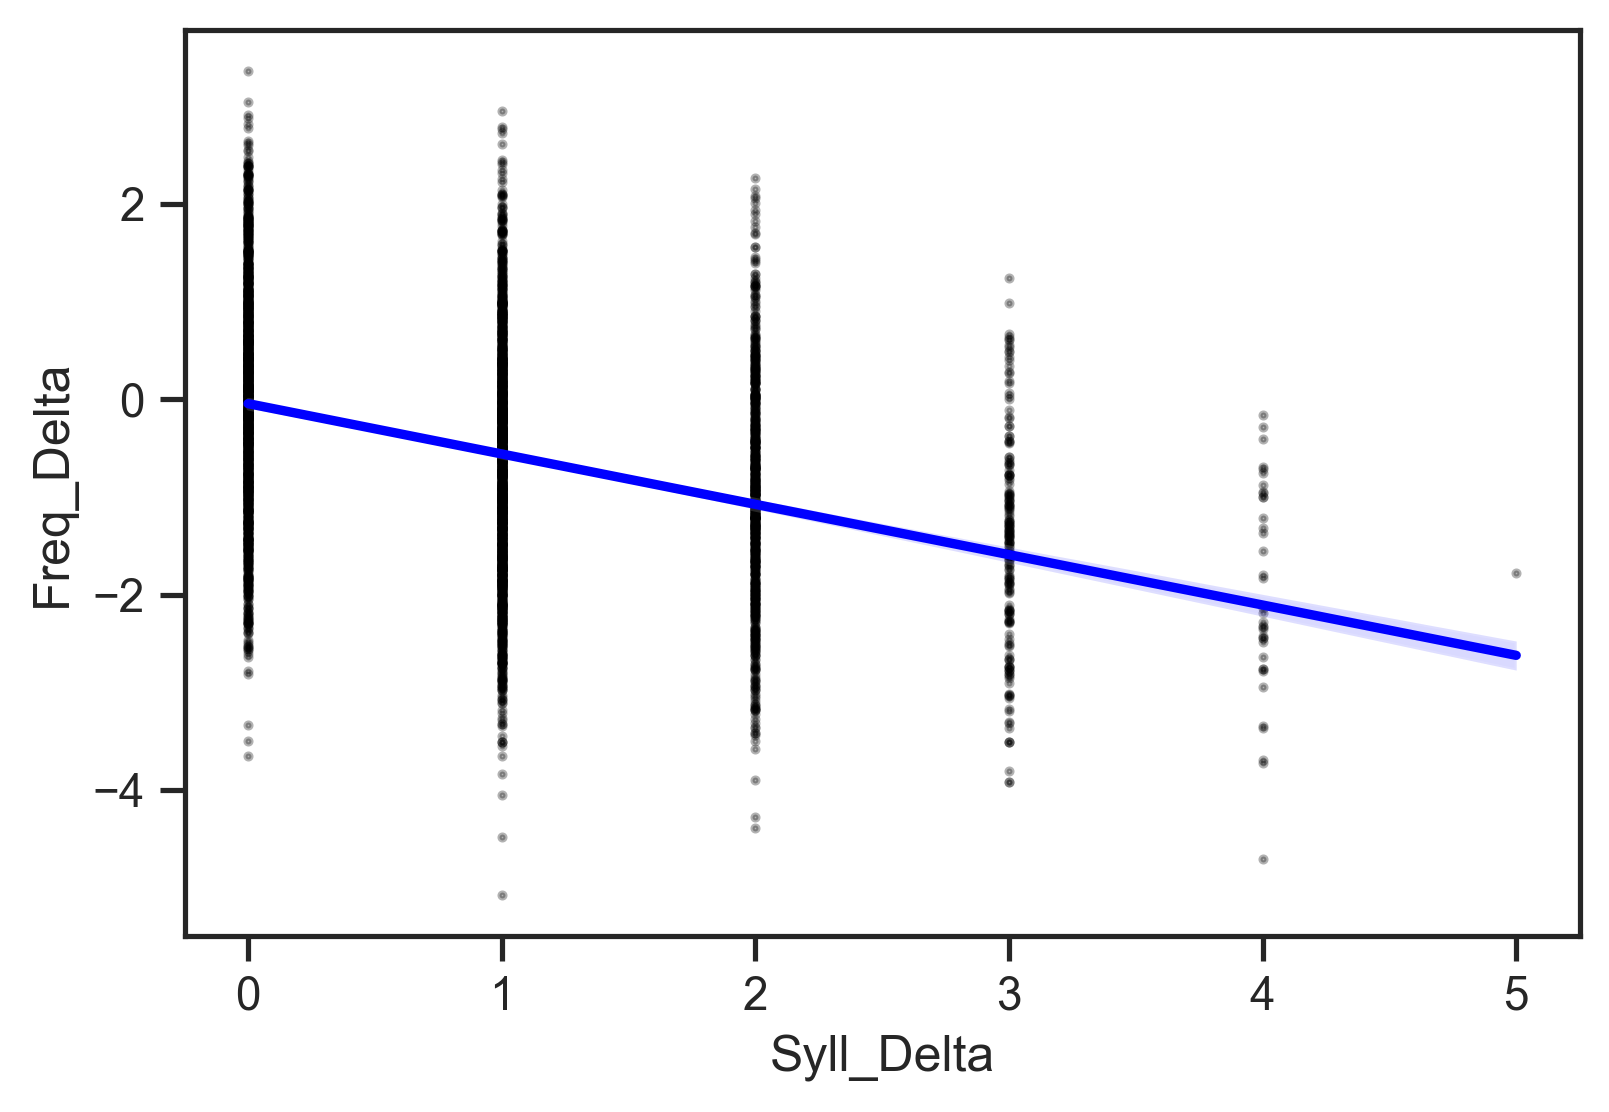

In [50]:
sns.regplot(y = final_df["Freq_Delta"], x = final_df["Syll_Delta"],
            scatter_kws = {"color": "black", "alpha": 0.3,'s':2},
            line_kws = {"color": "blue"},
            ci = 95) 